This notebook is an implementation of the Krumhansl-Schmuckler key-finding algorithm as described on http://rnhart.net/articles/key-finding/. We split up the music using self-similarity matrices and then apply the algorithm to each part.


Imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import resample
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline
import IPython.display
import librosa
import librosa.display
import math
from scipy.signal import find_peaks_cwt
from scipy.spatial import distance

Load the desired music file using librosa.

In [6]:
path = "/home/student/data/cs4065/demo/chris/Klassiek.mp3"
y, sr = librosa.load(path)
number_of_audio_samples = len(y)
audio_duration = float(number_of_audio_samples / float(sr))

def next_pow_2(x):
    return 1 << (x - 1).bit_length()

audio_frame_size = next_pow_2(int(sr / 4.0))  # i.e., about 0.25 seconds.
audio_hop_size = int(audio_frame_size / 2.0)  # i.e., 50% overlap.

Calculate and resample the Chroma matrix.

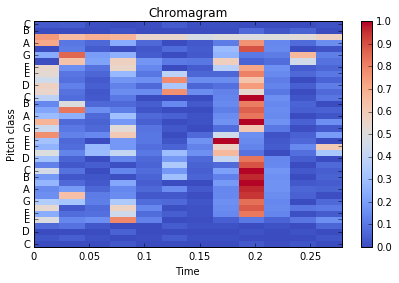

In [7]:
chroma_matrix = librosa.feature.chroma_stft(y, n_fft=audio_frame_size, hop_length=audio_hop_size)

number_of_seconds = int(np.round(audio_duration))
chroma_matrix_resampled = np.array(resample(chroma_matrix.transpose(), number_of_seconds))

del chroma_matrix

# Show resampled chromagram
librosa.display.specshow(chroma_matrix_resampled, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

plt.title('Chromagram')
plt.colorbar()

plt.tight_layout()

Calculate the self-similarity matrix from the chromogram.

<IPython.core.display.Javascript object>


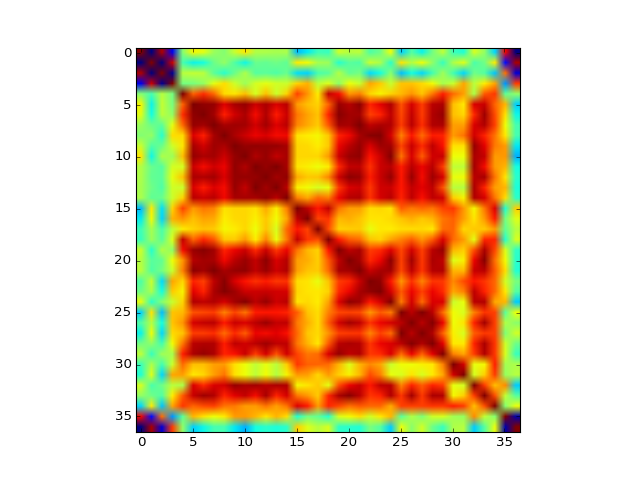

In [8]:
chroma_self_similarity = np.zeros((len(chroma_matrix_resampled), len(chroma_matrix_resampled)))
for (i, v1) in enumerate(chroma_matrix_resampled):
    for (j, v2) in enumerate(chroma_matrix_resampled):
        chroma_self_similarity[i][j] = np.sum(v1 * v2) / float(np.sqrt(np.sum(np.square(v1))) * np.sqrt(np.sum(np.square(v2))))

# Show the matrix
%matplotlib notebook
plt.figure()
plt.imshow(chroma_self_similarity)

Compute novelty by moving a Gaussian checkerboard kernel over the diagonal of the self-similarity matrix.

<IPython.core.display.Javascript object>


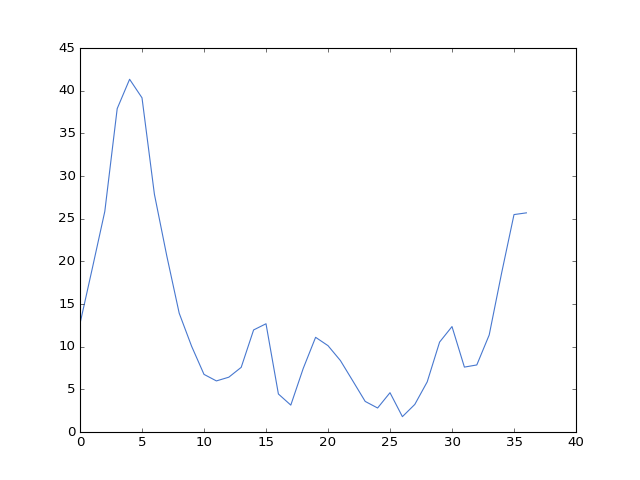

In [9]:
def compute_checkerboard_kernel(kernel_size = 10):
  # This is the size on a side of the kernel.
  kernel_side = int(np.ceil(kernel_size / 2.0))

  # Initialize.
  kernel = np.ones((kernel_size, kernel_size))
  
  # Set the top-right and bottom-left blocks to -1.
  kernel[0:kernel_side, kernel_side:] = -1.0
  kernel[kernel_side:, 0:kernel_side] = -1.0
  
  return kernel

def compute_gaussian_checkerboard_kernel(kernel_size = 10):
  # This is the size on a side of the kernel.
  kernel_side = int(np.ceil(kernel_size / 2.0))

  # Initialize.
  kernel = compute_checkerboard_kernel(kernel_size)
    
  for x in xrange(0, kernel_size):
    for y in xrange(0, kernel_size):
        kernel[x][y] = kernel[x][y] * math.exp(-4 * (  (((x - kernel_side) ** 2) / float(kernel_side ** 2)) + (((y - kernel_side) ** 2) / float(kernel_side ** 2))))
  
  return kernel

def compute_novelty(self_similarity_matrix, kernel):
  diag_length = np.shape(self_similarity_matrix)[0]
  kernel_size = np.shape(kernel)[0]
  kernel_size_half = int(np.ceil(kernel_size / 2.0))
  
  # Pad the self-similarity matrix.
  padded_size = kernel_size + diag_length

  padded_self_sim_matrix = np.zeros((padded_size, padded_size))
  stop = - kernel_size_half + int(1 == kernel_size % 2)
  padded_self_sim_matrix[
      kernel_size_half:stop,
      kernel_size_half:stop] = self_similarity_matrix
  
  # Compute novelty.
  novelty = np.zeros(diag_length)
  for x in range(diag_length):
    stop = x + kernel_size
    sub_block = padded_self_sim_matrix[x:stop, x:stop]
    novelty[x] = np.sum(sub_block * kernel)  # Correlation between the kernel and the subblock.
    
  return novelty

audio_novelty = compute_novelty(chroma_self_similarity, compute_gaussian_checkerboard_kernel(32))

# Show novelty graph
%matplotlib notebook
plt.figure('Audio Novelty')
plt.plot(audio_novelty)

Detect peaks in the novelty curve.

<IPython.core.display.Javascript object>


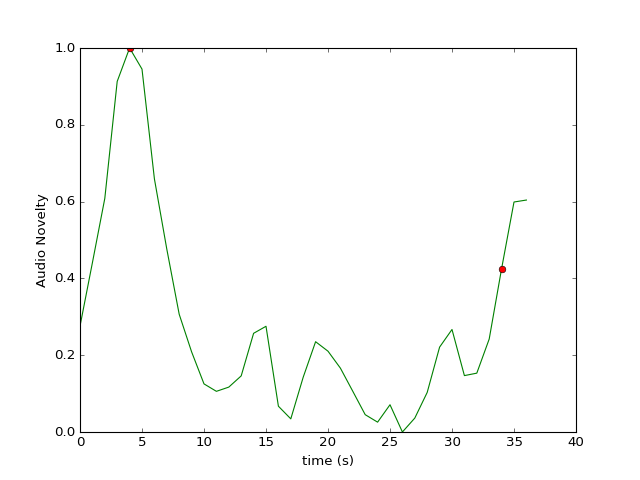

In [10]:
def scale_vector(v):
  return (v - np.min(v)) / (np.max(v) - np.min(v))

def detect_peaks(data, threshold = None):
  # Use scipy.signal.find_peaks_cwt to detect peaks.
  peaks_positions = np.array(
      find_peaks_cwt(data, np.arange(1, 10)))

  if 0 == len(peaks_positions):
    return []

  if threshold is not None:
    # Filter peaks by thresholding.
    mask = data[peaks_positions] > threshold
    peaks_positions = peaks_positions[mask]
  
  return peaks_positions

audio_novelty_normalized = scale_vector(audio_novelty)
audio_boundaries = detect_peaks(audio_novelty_normalized)

# Show peaks
%matplotlib notebook
fig = plt.figure()
plt.plot(audio_novelty_normalized, 'g')
plt.plot(audio_boundaries, audio_novelty_normalized[audio_boundaries], 'or')
plt.xlabel('time (s)')
plt.ylabel('Audio Novelty')

The Krumhansl-Schmuckler key-finding algorithm.

In [22]:
# All keys, to be used for display
keys = [
    'C major',
    'C# major',
    'D major',
    'D# major',
    'E major',
    'F major',
    'F# major',
    'G major',
    'G# major',
    'A major',
    'A# major',
    'B major',
    
    'C minor',
    'C# minor',
    'D minor',
    'D# minor',
    'E minor',
    'F minor',
    'F# minor',
    'G minor',
    'G# minor',
    'A minor',
    'A# minor',
    'B minor',
]

# The profile for the major key, indicating how strong we expect to see the notes compared to the root note.
major_profile = [
    6.35,
    2.23,
    3.48,
    2.33,
    4.38,
    4.09,
    2.52,
    5.19,
    2.39,
    3.66,
    2.29,
    2.88
]

# The profile for the minor key
minor_profile = [
    6.33,
    2.68,
    3.52,
    5.38,
    2.60,
    3.53,
    2.54,
    4.75,
    3.98,
    2.69,
    3.34,
    3.17
]

# Sum all note intensities of the chromogram
def sum_notes(C):
    return np.sum(C, (1))

# Sum all notes but only if a certain threshold is reached
def threshold(C, threshold):
    durations = [0] * 12
    for i in range(0, np.shape(C)[0]):
        for j in range(0, np.shape(C)[1]):
            if(C[i][j] >= threshold):
                durations[i] += 1
    return durations

def sq(x):
    return x * x

# Calculate the correlation between a profile and note durations
def calc_correlation(profile, durations):
    mean_x = np.average(profile)
    mean_y = np.average(durations)
    
    sum1 = np.sum((x - mean_x) * (y - mean_y) for (x, y) in zip(profile, durations))
    sum2 = np.sum(sq(x - mean_x) for x in profile)
    sum3 = np.sum(sq(y - mean_y) for y in durations)
    
    cor = 0
    if sum2 != 0 and sum3 != 0:
        cor = sum1 / np.sqrt(sum2 * sum3)
    
    return cor

def rotate(arr, i):
    l = len(arr)
    res = []
    for j in xrange(0, l):
        res.append(arr[(j + i) % l])
    return res

# Calculate the correlations between the profiles and the note durations, rotating the durations for each note
def schmuckler(durations, major, minor, top = 1):
    correlations_major = [calc_correlation(major_profile, rotate(durations, i)) for i in xrange(0, 12)]
    correlations_minor = [calc_correlation(minor_profile, rotate(durations, i)) for i in xrange(0, 12)]
    correlations = correlations_major + correlations_minor
    x = sorted(enumerate(correlations), key=lambda x: -x[1])
    return map(lambda x: (keys[x[0]], x[1]), x)[0: top]

# Get the key of a chromogram by summing all the note intensities
def schmuckler_note_sum(C, top = 1):
    return schmuckler(sum_notes(C), major_profile, minor_profile, top)

# Get the key of a chromogram by summing all the note intensities with a threshold
def schmuckler_threshold(C, top = 1, t = 0.8):
    return schmuckler(threshold(C, t), major_profile, minor_profile, top)

# cut the chromagram in pieces
def cut_chroma(C, boundaries, t = 0):
    last = 0
    r = []
    for b in boundaries:
        if (b - last) >= t:
            r.append(C[last:b])
            last = b
    r.append(C[last:len(C)])
    return r

# Cut the chromogram in pieces using the boundaries calculated from the peaks in the novelty curve
C = cut_chroma(chroma_matrix_resampled, audio_boundaries)

# Calculate the keys
note_sum_whole = schmuckler_note_sum(chroma_matrix_resampled.transpose())
threshold_whole = schmuckler_threshold(chroma_matrix_resampled.transpose())
note_sum = map(lambda c: schmuckler_note_sum(c.transpose()), C)
threshold = map(lambda c: schmuckler_threshold(c.transpose()), C)

print 'Whole song, no threshold:', note_sum_whole[0][0], note_sum_whole[0][1]
print 'Whole song, with threshold (0.8):', threshold_whole[0][0], threshold_whole[0][1]
print
last = 0
for (i, b) in enumerate(audio_boundaries):
    print last, 's -', b, 's:'
    print 'No threshold:', note_sum[i][0][0], note_sum[i][0][1]
    print 'With threshold (0.8):', threshold[i][0][0], threshold[i][0][1]
    last = b
print last, 's -', len(chroma_matrix_resampled), 's:'
print 'No threshold:', note_sum[i][0][0], note_sum[i][0][1]
print 'With threshold (0.8):', threshold[i][0][0], threshold[i][0][1]

Whole song, no threshold: G# major 0.864492259355
Whole song, with threshold (0.8): G# major 0.69870012783

0 s - 4 s:
No threshold: C# minor 0.238428824211
With threshold (0.8): C major 0
4 s - 34 s:
No threshold: G# major 0.862442158111
With threshold (0.8): G# major 0.69870012783
34 s - 37 s:
No threshold: G# major 0.862442158111
With threshold (0.8): G# major 0.69870012783
